In [35]:
from keras.models import Sequential
from keras.layers import Dropout, Dense
from sklearn.datasets import make_regression
from talos.utils import hidden_layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

import sys
import talos

In [36]:
#china dataset that doesn't work
df = pd.read_csv("preproc.csv") 
train, test = train_test_split(df, test_size=0.2)
train = train.drop(['Date','1d'], axis = 1)
test = test.drop(['Date','1d'], axis = 1)

train_y = train[train.columns[1]].values
train_x = train.drop(['PM2.5'], axis = 1).values

test_y = test[test.columns[1]].values
test_x = test.drop(['PM2.5'], axis = 1).values

normalizer = MinMaxScaler(feature_range = (0, 1))
train_x = normalizer.fit_transform(train_x)
test_x = normalizer.fit_transform(test_x)

train_y = train_y.reshape(-1, 1)
train_y = normalizer.fit_transform(train_y)
test_y = test_y.reshape(-1, 1)
test_y = normalizer.fit_transform(test_y)

In [37]:
#base = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
#base = base.dropna()
#base = base.drop('No', axis = 1)
#base = base.drop('year', axis = 1)
#base = base.drop('month', axis = 1)
#base = base.drop('day', axis = 1)
#base = base.drop('hour', axis = 1)
#base = base.drop('cbwd', axis = 1)

#train = base.iloc[:, 1:7].values
#target = base.iloc[:, 0].values

#normalizador = MinMaxScaler(feature_range = (0, 1))
#train = normalizador.fit_transform(train)

#target = target.reshape(-1, 1)
#target = normalizador.fit_transform(target)

In [38]:
# first we have to make sure to input data and params into the function
def create_model(x_train, y_train, x_val, y_val, params):

    model = Sequential()
    
    # Add first hidden layer with input_dim of input features
    model.add(Dense(params['number_of_neurons'], input_dim=x_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    # Add second hidden layer
    model.add(Dense(params['number_of_neurons'],
                    activation=params['activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    # Add final layer with a linear activation function
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    # Compile neural network
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'],
                  metrics=['mse'])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[talos.utils.live()],
                        epochs=params['epochs'],
                        verbose=0)

    return history, model

In [39]:
# then we can go ahead and set the parameter space
p = {'number_of_neurons':[1,25,50,75,100,125,150,175,200],
     'lr': [0.00001,0.0001,0.001,0.01,0.2,0.3,0.5,0.7,1],
     'batch_size': [30],
     'epochs': [100],
     'dropout': [0],
     'kernel_initializer': ['uniform'],
     'optimizer': ['Adam'],
     'losses': ['mse'],
     'activation':['relu'],
     'last_activation': ['linear']}

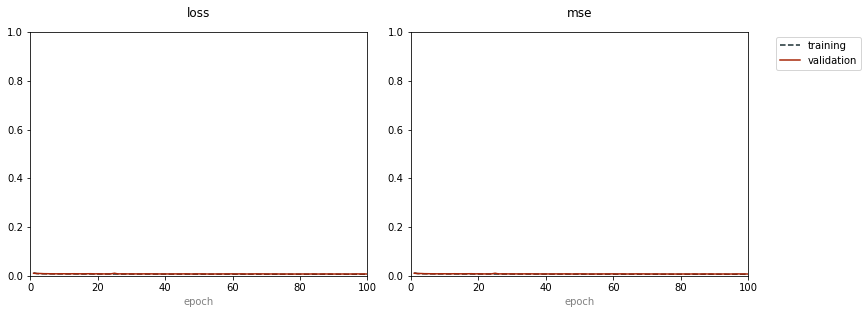

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:42<00:00, 102.14s/it]


In [40]:
# and run the experiment
t = talos.Scan(x=train_x,
               y=train_y,
               model=create_model,
               params=p,
               experiment_name='normalized-both')

In [41]:
analyze_object = talos.Analyze(t)
analyze_object.data

,round_epochs,val_loss,val_mse,loss,mse,activation,batch_size,dropout,epochs,kernel_initializer,last_activation,losses,lr,number_of_neurons,optimizer
0,100,0.00723,0.00723,0.006389,0.006389,relu,30,0,100,uniform,linear,mse,0.2,200,Adam


In [42]:
analyze_object.low('val_loss')

0.007230389356079799

In [43]:
e = talos.Evaluate(t)
evaluation = e.evaluate(test_x, 
                        test_y, 
                        model_id=None, 
                        folds=10,
                        shuffle=True, 
                        metric='val_loss', 
                        asc=True,
                        task = "continuous")
evaluation

[0.07588772593055518,
 0.08248464804442317,
 0.08281730685481535,
 0.077726203480044,
 0.07655747522715843,
 0.07908551074802811,
 0.07806217150515607,
 0.07938888145832645,
 0.07949414210654504,
 0.08104184068261817]

In [44]:
p = talos.Predict(t)
test_pred_y = p.predict(test_x, metric = 'val_loss', asc = True)

print(test_pred_y)
print(test_y)

[[0.38652694]
 [0.11857204]
 [0.07672548]
 ...
 [0.2150569 ]
 [0.15852366]
 [0.09665214]]
[[0.78165138]
 [0.0477404 ]
 [0.02714067]
 ...
 [0.09021407]
 [0.01554536]
 [0.11051648]]


In [45]:
test_pred_y = normalizer.inverse_transform(test_pred_y)
test_y = normalizer.inverse_transform(test_y)

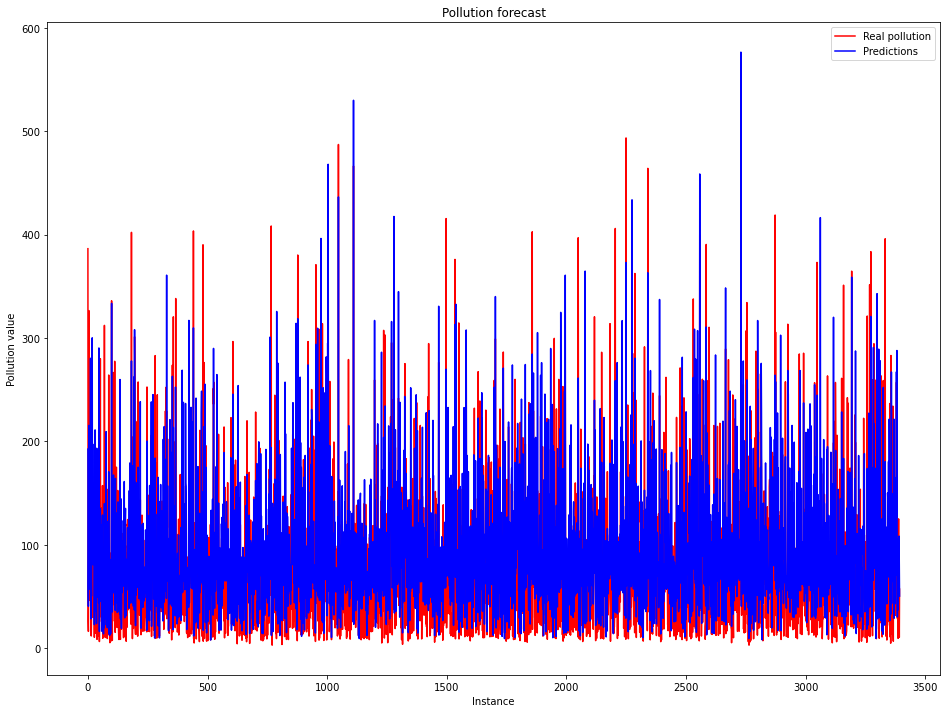

In [46]:
plt.figure(figsize=(16,12))
plt.plot(test_y, color = 'red', label = 'Real pollution')
plt.plot(test_pred_y, color = 'blue', label = 'Predictions')
plt.title('Pollution forecast')
plt.xlabel('Instance')
plt.ylabel('Pollution value')
plt.legend()

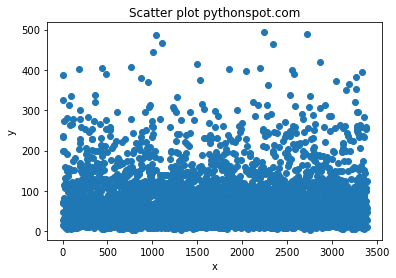

In [47]:
x = np.arange(3393)
y = test_y

# Plot
plt.scatter(x, y)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

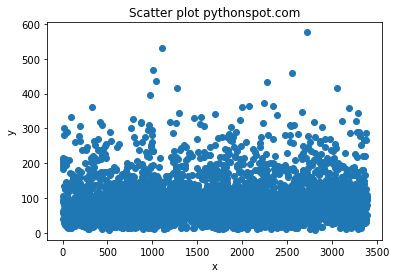

In [48]:
x = np.arange(3393)
y = test_pred_y

# Plot
plt.scatter(x, y)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()